In [22]:
# @title Contact Software Sushi {"display-mode":"form"}
import base64
import requests
import urllib.request
from IPython.display import display, HTML

image_url = "https://raw.githubusercontent.com/SoftwareSushi/marketing-resources/main/images/company/logo.png"
with urllib.request.urlopen(image_url) as response:
    image_data = response.read()
    encoded_image = base64.b64encode(image_data).decode()

def load_html_from_github(raw_url):
    response = requests.get(raw_url)
    html_content = response.text
    updated_html = html_content.replace('../images/logo.png', f"data:image/png;base64, {encoded_image}")
    display(HTML(updated_html))

load_html_from_github('https://raw.githubusercontent.com/SoftwareSushi/marketing-resources/refs/heads/main/html/cta-banner-with-logo.html')


# PDF Document Layout Analysis Tool

This notebook demonstrates a powerful tool for analyzing and extracting the structural layout of PDF documents. Using computer vision and deep learning techniques, it automatically identifies different elements such as text blocks, titles, figures, tables, and lists within PDFs.

## Key Features

- **Multi-model support**: Choose from different pre-trained models optimized for scientific papers, general documents, or historical texts
- **Flexible processing**: Analyze individual pages or batch process multiple pages
- **Visual results**: Generate annotated visualizations showing detected layout elements
- **Data export**: Export structured layout data in JSON format for further processing
- **Customizable detection**: Adjust confidence thresholds and resolution settings

This tool is perfect for document understanding tasks, preparing data for text extraction, or analyzing document structure across large collections of PDFs.


# Setup

In [1]:
!pip install pillow==9.5.0 layoutparser PyMuPDF

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 60.3 MB/s eta 0:00:00
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=858ba2acc87b9bd8ecff1ee2cd5c3ffb76577b1baca4a31ee30c9003e435541b
  Stored in directory: /root/.cache/pip/wheels/ba/5e/16/6117f8fe7e9c0c161a795e10d94645ebcf301ccbd01f6

In [1]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2'

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-3bhmca75/detectron2_946cadd63ddc4158b892142e85f16fc1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-3bhmca75/detectron2_946cadd63ddc4158b892142e85f16fc1
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2-0.4-cp311-cp311-linux_x86_64.whl size=5951502 sha256=137085fa9d3350da71c926ea36881ac66186ba0256691e22598870c08e1f3c26
  Stored in directory: /tmp/pip-ephem-wheel-cache-tlw0tyrj/wheels/aa/c8/eb/ce81e9eaef24044d177d26f49d3a226e4a1940ae80a0799589
  Created wheel for fvcor

#Imports

In [24]:
import layoutparser as lp
from layoutparser.models import Detectron2LayoutModel
import cv2
import numpy as np
import matplotlib.pyplot as plt
import fitz  # PyMuPDF
from PIL import Image
import io
import os
import argparse

# Code

In [17]:
def load_pdf_page_as_image(pdf_path, page_num=0, dpi=300):
    """
    Load a specific page from a PDF file as an image.

    Args:
        pdf_path (str): Path to the PDF file
        page_num (int): Page number to load (0-indexed)
        dpi (int): Resolution for rendering the page

    Returns:
        numpy.ndarray: The page as an OpenCV image (RGB format)
    """
    # Open the PDF file
    doc = fitz.open(pdf_path)

    if page_num >= len(doc):
        raise ValueError(f"PDF has only {len(doc)} pages, requested page {page_num}")

    # Get the specified page
    page = doc.load_page(page_num)

    # Render page to an image
    pix = page.get_pixmap(matrix=fitz.Matrix(dpi / 72, dpi / 72))

    # Convert to PIL Image
    img = Image.open(io.BytesIO(pix.tobytes()))

    # Convert to OpenCV format (RGB)
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    return img_cv


def detect_layout(image, model_type="PubLayNet", threshold=0.8):
    """
    Detect layout elements in an image using LayoutParser.

    Args:
        image (numpy.ndarray): Input image in OpenCV format
        model_type (str): Type of pre-trained model to use
        threshold (float): Detection confidence threshold

    Returns:
        layoutparser.Layout: Detected layout elements
    """
    # Model configuration based on type
    model_catalog = {
        "PubLayNet": {
            "config": "lp://PubLayNet/mask_rcnn_X_101_32x8d_FPN_3x/config",
            "label_map": {0: "Text", 1: "Title", 2: "List", 3: "Table", 4: "Figure"},
        },
        "PrimaLayout": {
            "config": "lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config",
            "label_map": {
                1: "TextRegion",
                2: "ImageRegion",
                3: "TableRegion",
                4: "MathsRegion",
                5: "SeparatorRegion",
            },
        },
        "HJDataset": {
            "config": "lp://HJDataset/faster_rcnn_R_50_FPN_3x/config",
            "label_map": {
                0: "Page",
                1: "Text",
                2: "Title",
                3: "Figure",
                4: "Table",
                5: "List",
            },
        },
    }

    if model_type not in model_catalog:
        raise ValueError(
            f"Model type '{model_type}' not supported. Choose from: {list(model_catalog.keys())}"
        )

    model_config = model_catalog[model_type]

    # Initialize the layout model
    model = lp.models.Detectron2LayoutModel(
        model_config["config"],
        extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", threshold],
        label_map=model_config["label_map"],
    )

    # Detect layout elements
    layout = model.detect(image)

    return layout


def visualize_layout(image, layout, save_path=None, show_plot=True):
    """
    Visualize the detected layout elements on the image.

    Args:
        image (numpy.ndarray): Input image
        layout (layoutparser.Layout): Detected layout elements
        save_path (str, optional): Path to save the visualized layout
        show_plot (bool): Whether to display the plot interactively

    Returns:
        numpy.ndarray: Annotated image
    """
    # Create a deep copy of the image to avoid modifying the original
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    color_map = {
    "Text": (255, 0, 0),    # Blue
    "Title": (0, 255, 0),   # Green
    "List": (0, 0, 255),    # Red
    "Table": (0, 255, 255), # Yellow
    "Figure": (255, 0, 255) # Purple
    }

    for block in layout:
      color = color_map.get(block.type, (0, 0, 0))  # Default to black
      x1, y1, x2, y2 = map(int, block.coordinates)
      cv2.rectangle(image_rgb, (x1, y1), (x2, y2), color, thickness=2)

    # Optionally, add labels
    for block in layout:
        label = block.type
        x1, y1, _, _ = map(int, block.coordinates)
        font_scale = 0.9
        font_thickness = 2

        # Draw text background for readability
        (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, font_scale, font_thickness)
        cv2.rectangle(image_rgb, (x1, y1), (x1 + text_w + 4, y1 + text_h + 4), (255, 255, 255), -1)

        # Draw label text
        cv2.putText(image_rgb, label, (x1 + 2, y1 + text_h + 2), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (0, 0, 0), font_thickness)

    image_rgb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

    if show_plot:
        # Display the visualization
        plt.figure(figsize=(15, 15))
        plt.imshow(image_rgb)
        plt.axis("off")

        # Save the visualization if requested
        if save_path:
            plt.savefig(save_path, bbox_inches="tight", dpi=300)

        plt.show()
    else:
        # Just save without displaying
        if save_path:
            plt.figure(figsize=(15, 15))
            plt.imshow(image_rgb)
            plt.axis("off")
            plt.savefig(save_path, bbox_inches="tight", dpi=300)
            plt.close()

    return image_rgb


def process_pdf(
    pdf_path,
    page_num=0,
    output_dir="output",
    model_type="PubLayNet",
    threshold=0.8,
    dpi=300,
    show_plot=True,
):
    """
    Process a PDF page: load, detect layout, and visualize.

    Args:
        pdf_path (str): Path to the PDF file
        page_num (int): Page number to process
        output_dir (str): Directory to save output
        model_type (str): Type of layout model to use
        threshold (float): Detection confidence threshold
        dpi (int): Resolution for rendering the page
        show_plot (bool): Whether to display plot interactively

    Returns:
        layoutparser.Layout: Detected layout elements
    """
    # Create output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Generate output filename
    pdf_name = os.path.splitext(os.path.basename(pdf_path))[0]
    output_path = os.path.join(output_dir, f"{pdf_name}_page{page_num}_layout.png")

    # Load PDF page as image
    print(f"Loading page {page_num} from {pdf_path}...")
    image = load_pdf_page_as_image(pdf_path, page_num, dpi)

    # Detect layout
    print(f"Detecting layout elements using {model_type} model...")
    layout = detect_layout(image, model_type, threshold)

    # Visualize and save
    print(f"Visualizing layout and saving to {output_path}...")
    visualize_layout(image, layout, save_path=output_path, show_plot=show_plot)

    print("Processing complete!")

    # Return layout for potential further processing
    return layout


def process_multiple_pages(pdf_path, start_page=0, end_page=None, **kwargs):
    """
    Process multiple pages from a PDF.

    Args:
        pdf_path (str): Path to the PDF file
        start_page (int): First page to process (0-indexed)
        end_page (int): Last page to process (None means all pages)
        **kwargs: Additional arguments passed to process_pdf

    Returns:
        dict: Page number to layout mapping
    """
    # Open the PDF to get page count if end_page is None
    if end_page is None:
        doc = fitz.open(pdf_path)
        end_page = len(doc) - 1

    layouts = {}
    for page_num in range(start_page, end_page + 1):
        print(f"\nProcessing page {page_num}...")
        try:
            layout = process_pdf(pdf_path, page_num, **kwargs)
            layouts[page_num] = layout
        except Exception as e:
            print(f"Error processing page {page_num}: {e}")

    return layouts


def export_layout_data(layouts, output_path):
    """
    Export layout data to a JSON file.

    Args:
        layouts (dict): Dictionary mapping page numbers to layouts
        output_path (str): Path to save JSON data
    """
    data = {}

    for page_num, layout in layouts.items():
        page_data = []
        for block in layout:
            block_data = {
                "type": block.type,
                "confidence": float(block.score),
                "coordinates": {
                    "x1": int(block.coordinates[0]),
                    "y1": int(block.coordinates[1]),
                    "x2": int(block.coordinates[2]),
                    "y2": int(block.coordinates[3]),
                },
            }
            page_data.append(block_data)

        data[str(page_num)] = page_data

    # Convert to JSON and save
    import json

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2)

    print(f"Layout data exported to {output_path}")


def main(args):
    # Check if the PDF file exists
    if not os.path.isfile(args.pdf):
        print(f"PDF file not found: {args.pdf}")
        print("You can run 'python download_sample_pdf.py' to download a sample PDF.")
        return

    # Process single page or multiple pages
    if args.start_page is not None or args.end_page is not None:
        # Multi-page processing
        start = args.start_page if args.start_page is not None else 0
        end = args.end_page

        layouts = process_multiple_pages(
            args.pdf,
            start_page=start,
            end_page=end,
            output_dir=args.output,
            model_type=args.model,
            threshold=args.threshold,
            dpi=args.dpi,
            show_plot=not args.no_display,
        )
    else:
        # Single page processing
        layout = process_pdf(
            args.pdf,
            page_num=args.page,
            output_dir=args.output,
            model_type=args.model,
            threshold=args.threshold,
            dpi=args.dpi,
            show_plot=not args.no_display,
        )
        layouts = {args.page: layout}

    # Export layout data if requested
    if args.export_json:
        pdf_name = os.path.splitext(os.path.basename(args.pdf))[0]
        json_path = os.path.join(args.output, f"{pdf_name}_layout.json")
        export_layout_data(layouts, json_path)

    # Print summary
    total_elements = sum(len(layout) for layout in layouts.values())
    print(f"\nProcessed {len(layouts)} pages with {total_elements} layout elements.")

    # Print element counts by type
    element_counts = {}
    for layout in layouts.values():
        for element in layout:
            element_type = element.type
            if element_type not in element_counts:
                element_counts[element_type] = 0
            element_counts[element_type] += 1

    print("\nElement counts by type:")
    for element_type, count in element_counts.items():
        print(f"  {element_type}: {count}")


# Run

# PDF Layout Analysis Parameters

### Document Input and Output
- **Upload PDF**: Upload the PDF file you want to analyze using the file upload button.
- **Output Directory**: Directory where visualizations and output files will be saved. Default is "output".

### Page Selection
- **Processing Mode**: Choose between processing a single page or multiple pages.
- **Single Page Number**: When in single page mode, specify which page to process (0-indexed).
- **Start Page**: When in multiple pages mode, specify the first page to process (0-indexed).
- **End Page**: When in multiple pages mode, specify the last page to process.

### Model Configuration
- **Model Type**: Layout detection model to use. Options include:
  - "PubLayNet": Trained on scientific documents (default)
  - "PrimaLayout": General document layout
  - "HJDataset": Historical Japanese documents

### Processing Options
- **Confidence Threshold**: Detection confidence threshold (0.1-1.0). Higher values produce fewer but more confident detections.
- **DPI Setting**: Resolution for rendering PDF pages. Higher values (300+) give better quality but require more processing power.
- **Display Plots**: When checked, visualizations will be displayed interactively. Uncheck for batch processing.
- **Export JSON Data**: When checked, layout data will be exported in JSON format for further processing.


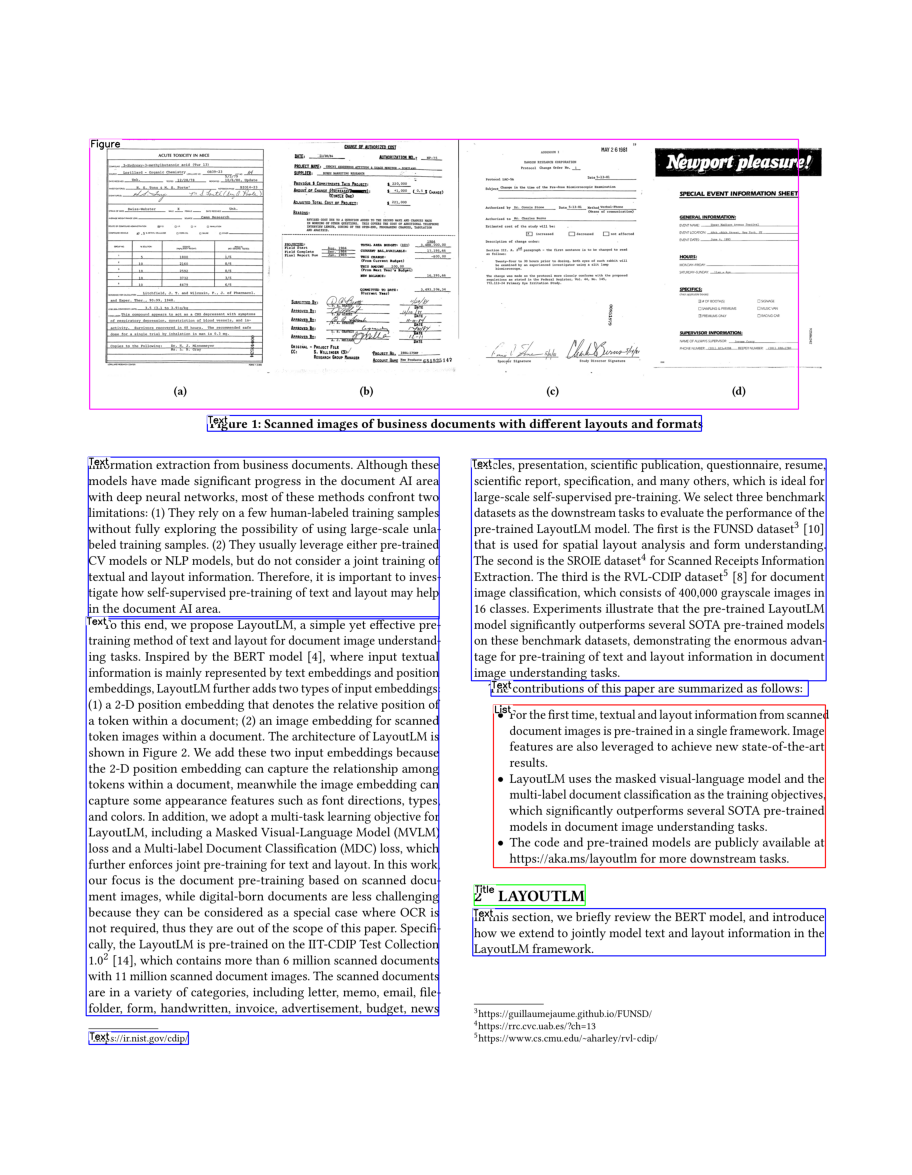

Processing complete!

Processing page 2...
Loading page 2 from sample.pdf...
Detecting layout elements using PubLayNet model...
Visualizing layout and saving to output/sample_page2_layout.png...


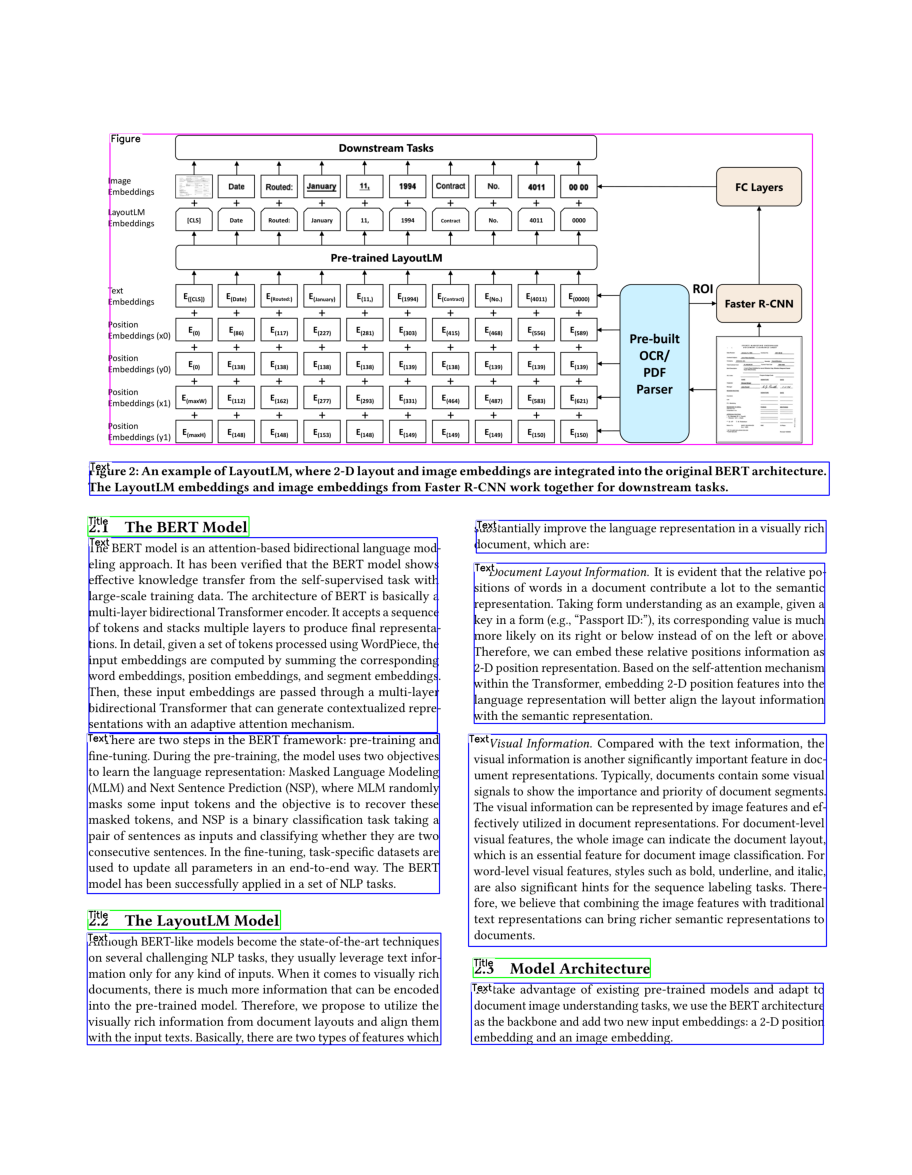

Processing complete!
Layout data exported to output/sample_layout.json

Processed 3 pages with 39 layout elements.

Element counts by type:
  Title: 10
  Text: 26
  Figure: 2
  List: 1


FileUpload(value={}, accept='.pdf', description='Upload PDF')

In [31]:
# @title Form {"display-mode":"form"}
from google.colab import files
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Upload widget for PDF files
upload_button = widgets.FileUpload(
    description='Upload PDF',
    accept='.pdf',
    multiple=False
)
display(upload_button)

# Form for parameters
form = widgets.VBox([
    widgets.HTML(value="<h3>PDF Layout Analysis Parameters</h3>"),

    widgets.Text(
        value='output',
        description='Output Directory:',
        style={'description_width': 'initial'}
    ),

    widgets.RadioButtons(
        options=['Single Page', 'Multiple Pages'],
        value='Multiple Pages',
        description='Processing Mode:',
        style={'description_width': 'initial'}
    ),

    widgets.IntText(
        value=0,
        description='Single Page Number:',
        disabled=True,
        style={'description_width': 'initial'}
    ),

    widgets.IntText(
        value=0,
        description='Start Page:',
        style={'description_width': 'initial'}
    ),

    widgets.IntText(
        value=3,
        description='End Page:',
        style={'description_width': 'initial'}
    ),

    widgets.Dropdown(
        options=['PubLayNet', 'PrimaLayout', 'HJDataset'],
        value='PubLayNet',
        description='Model Type:',
        style={'description_width': 'initial'}
    ),

    widgets.FloatSlider(
        value=0.8,
        min=0.1,
        max=1.0,
        step=0.05,
        description='Confidence Threshold:',
        style={'description_width': 'initial'}
    ),

    widgets.IntText(
        value=300,
        description='DPI Setting:',
        style={'description_width': 'initial'}
    ),

    widgets.Checkbox(
        value=True,
        description='Display Plots',
        style={'description_width': 'initial'}
    ),

    widgets.Checkbox(
        value=True,
        description='Export JSON Data',
        style={'description_width': 'initial'}
    ),

    widgets.Button(
        description='Run Analysis',
        button_style='success'
    )
])

# Processing mode selector logic
def toggle_page_inputs(change):
    if change['new'] == 'Single Page':
        form.children[3].disabled = False  # Enable single page
        form.children[4].disabled = True   # Disable start page
        form.children[5].disabled = True   # Disable end page
    else:
        form.children[3].disabled = True   # Disable single page
        form.children[4].disabled = False  # Enable start page
        form.children[5].disabled = False  # Enable end page

form.children[2].observe(toggle_page_inputs, names='value')

class Args:
    def __init__(
        self,
        pdf,
        output,
        page,
        start_page,
        end_page,
        model,
        threshold,
        dpi,
        no_display,
        export_json,
    ):
        self.pdf = pdf
        self.output = output
        self.page = page
        self.start_page = start_page
        self.end_page = end_page
        self.model = model
        self.threshold = threshold
        self.dpi = dpi
        self.no_display = no_display
        self.export_json = export_json


# Run button click handler
def on_run_button_clicked(b):
    clear_output(wait=True)

    # Save uploaded PDF
    if not upload_button.value:
        print("Please upload a PDF file first!")
        display(upload_button)
        display(form)
        return

    pdf_filename = next(iter(upload_button.value))
    pdf_content = upload_button.value[pdf_filename]['content']

    with open(pdf_filename, 'wb') as f:
        f.write(pdf_content)

    # Collect parameters from form
    output_dir = form.children[1].value
    processing_mode = form.children[2].value
    single_page = form.children[3].value if processing_mode == 'Single Page' else None
    start_page = form.children[4].value if processing_mode == 'Multiple Pages' else None
    end_page = form.children[5].value if processing_mode == 'Multiple Pages' else None
    model_type = form.children[6].value
    threshold = form.children[7].value
    dpi_setting = form.children[8].value
    display_plots = form.children[9].value
    export_json = form.children[10].value

    # Print selected parameters
    print(f"PDF: {pdf_filename}")
    print(f"Output Directory: {output_dir}")
    print(f"Model: {model_type}")
    print(f"Confidence Threshold: {threshold}")
    print(f"DPI: {dpi_setting}")

    if processing_mode == 'Single Page':
        print(f"Processing single page: {single_page}")
    else:
        print(f"Processing pages {start_page} to {end_page}")

    # Create Args object and run analysis
    args = Args(
        pdf=pdf_filename,
        output=output_dir,
        page=single_page,
        start_page=start_page,
        end_page=end_page,
        model=model_type,
        threshold=threshold,
        dpi=dpi_setting,
        no_display=not display_plots,
        export_json=export_json
    )

    print("\nStarting PDF layout analysis...")
    main(args)

form.children[-1].on_click(on_run_button_clicked)
display(form)